# Many body localization in 1-D qubit array

This simulation is based on the paper -- "Quantum Neuronal Sensing of Quantum Many-Body States on a 61-Qubit
Programmable Superconducting Processor", and aimed to demostrate the performance of quantum machine learning viaTeD-Q module. We further modify to 1-D qubit array to test the computing limit of the TeD-Q package
### Many Body localization
Many-body localization is a quantum phenomenon of an isolated many-body quantum system. The system tend to preserve the initial state under large disorder, known as localized state. On the other hand, with small disorder, the system tend to fall into the thermalization, that is, the infomation of initial state is washed out, known as ergodic state.

<img src="images/mbl_1d.png" width=600 />
(figure adapted from [2])

### Circuit design
The circuit design follows the one proposed in the paper. The circuit starts with an preparation stage for Neel state and followed by a system Hamiltonian with controllable disorder power. After that, the circuit is embeded with a variational cirucit via digital-analog architecture[1]. Finally, the measurement on first qubit is the output stage. We train the output probability to distinguish localized state from ergodic state.


### About this simulation
This circuit is suitable for the demostration of the computing power of TeD-Q package due to its complexity. In the simulated hamilonian of the system, the qubits was connected to all of its neighbor qubits. For a 1-D qubits array, such connection will introduce lot of 2-qubit operation and single-qubit operation, which becomes too complicated for the conventional quantum machine learning simulator.

## Reference
1. https://arxiv.org/pdf/2201.05957.pdf
2. https://arxiv.org/pdf/1804.11065.pdf
3. https://arxiv.org/pdf/1711.03145.pdf

In [1]:
import sys
sys.path.append('..')
import torch
import tedq as qai
import numpy as np
import math
from torch.optim import lr_scheduler
import torch.nn as nn

### init parameters

In [2]:
n_size = 3
n_epoch = 50
n_train = 40
n_test = 20

lr = 0.01
gamma_lr_scheduler = 0.2

n_qubits= n_size
t_d = 200e-9 #ns
h_bar = 1
g = 2.185e6 #MHz
h_erg = 1e6 # MHZ
h_loc = 40e6  # MHz

### Circuit definition

In [3]:
def getIndex(i, j):
    return n_size*i+j
def Hd(idx, jdx, di):
    #qai.RZ(2*h_bar*di*t_d, qubits=[jdx], trainable_params=[])
    qai.RZ(di, qubits=[jdx])
    H0(idx, jdx)
    
def H0(idx, jdx):
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    qai.CNOT(qubits=[idx, jdx])
    qai.RZ(torch.Tensor([g*h_bar*t_d]), qubits=[jdx], trainable_params=[])
    qai.CNOT(qubits=[idx, jdx])
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    
    qai.S(qubits=[idx])
    qai.S(qubits=[jdx])
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    qai.CNOT(qubits=[idx, jdx])
    qai.RZ(torch.Tensor([g*h_bar*t_d]), qubits=[jdx], trainable_params=[])
    qai.CNOT(qubits=[idx, jdx])
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    qai.PhaseShift(torch.tensor(-math.pi/2.), qubits=[idx], trainable_params=[])
    qai.PhaseShift(torch.tensor(-math.pi/2.), qubits=[jdx], trainable_params=[])

def partial_connected():
    for i in range(0, n_qubits-7, 5):
        qai.CNOT(qubits=[i, i+7])


def circuitDef(d, params):
    params = params.view(-1)
     
    # Neel state
    for i in range(n_qubits):
        if i%2==0:
            qai.PauliX(qubits=[i])
    
    # Hd td
    count = 0
    for i in range(n_qubits):
        if i>=0 and i+1<n_qubits:# (n_size-1)*n_size
            Hd(i+1, i, d[count])
            count+=1
        if i-1>=0 and i<n_qubits:# (n_size-1)*n_size
            Hd(i-1, i, d[count])
            count+=1    
            
    # Trainable theta and phi
    for i in range(n_qubits):
        #print(i)
        qai.RZ(params[2*i], qubits=[i])
        qai.RX(params[2*i+1], qubits=[i])
        qai.RZ(-params[2*i], qubits=[i])
    
    # Partial connection to increase complexity
    partial_connected()
    
    # H0 dt 
    for i in range(n_size):
        if i+1>=0 and i+1<n_qubits:# (n_size-1)*n_size
            H0(i+1, i)
        if i-1>=0 and i-1<n_qubits:# (n_size-1)*n_size
            H0(i-1, i)
            
    # Last rotation  
    qai.RZ(params[2*n_qubits], qubits=[n_qubits-1])
    qai.RX(params[2*n_qubits+1], qubits=[n_qubits-1])
    qai.RZ(-params[2*n_qubits], qubits=[n_qubits-1])

    # Measurement
    qai.measurement.probs(qubits=[n_qubits-1])
    


In [4]:
N = (n_size-1)*2

In [5]:
circuit = qai.Circuit(circuitDef, n_qubits, torch.rand(N), torch.rand(n_qubits+1,2))

### Draw the circuit

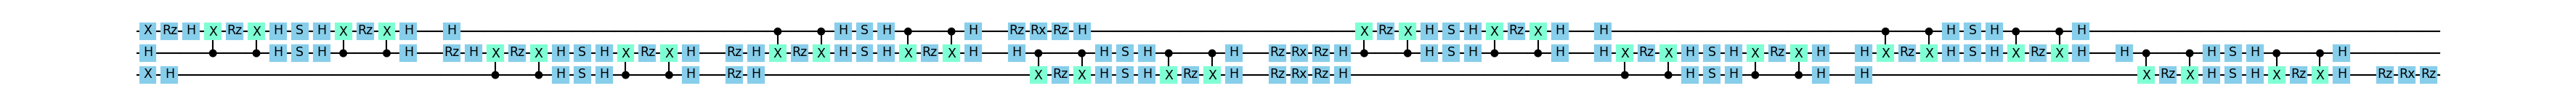

In [6]:
drawer = qai.matplotlib_drawer(circuit, dpi=300, scale=0.1)
drawer.draw_circuit()

### Compile the circuit

In [7]:
# Compiled the circuit by normal method
my_compilecircuit = circuit.compilecircuit(backend="pytorch_QUDIO")

in init


In [8]:
# # Compiled the circuit by hyper-optimized method
# from jdtensorpath import JDOptTN as jdopttn
# slicing_opts = None#{'target_size':2**28, 'repeats':500, 'target_num_slices':1, 'contract_parallel':False}
# hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'progbar':True, 'minimize':'flops', 'search_parallel':True, 'slicing_opts':slicing_opts}
# my_compilecircuit = circuit.compilecircuit(backend="pytorch", use_jdopttn=jdopttn, hyper_opt = hyper_opt, tn_simplify = False)

### Prepare the training data

In [9]:
params = torch.rand(n_qubits+1,2, requires_grad=True)


d_erg = torch.tensor(np.random.rand(int(n_train/2), N)*2-1)*h_erg*h_bar*t_d*math.pi
d_local = torch.tensor((np.random.rand(int(n_train/2), N)*39/40.+1/40.)*np.random.choice([-1., 1.], size=(int(n_train/2), N))*h_loc*h_bar*t_d*math.pi)
#d_local = torch.tensor(np.random.rand(int(n_train/2), N)*2-1)*h_loc*h_bar*t_d*math.pi
d = torch.cat((d_erg, d_local), 0)

y_target = torch.Tensor(np.array([1]*int(n_train/2)+[0]*int(n_train/2)))


### Train the QNN circuit

In [10]:
my_compilecircuit.set_dataset(d)


In [11]:
print(my_compilecircuit.device)

cpu


In [12]:
print(my_compilecircuit.dataset)

<bound method QUDIOBackend.dataset of <tedq.backends.qudio_backend.QUDIOBackend object at 0x7fb4ae7a88b0>>


In [13]:
print(my_compilecircuit.dataset)
cir_params = torch.cat((params, -params[:,0].view(-1,1)),1)
print(cir_params)
my_compilecircuit(cir_params)

<bound method QUDIOBackend.dataset of <tedq.backends.qudio_backend.QUDIOBackend object at 0x7fb4ae7a88b0>>
tensor([[ 0.9493,  0.9407, -0.9493],
        [ 0.6933,  0.2867, -0.6933],
        [ 0.3859,  0.0962, -0.3859],
        [ 0.3493,  0.7676, -0.3493]], grad_fn=<CatBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.5986, 0.4014]], grad_fn=<StackBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.3632, 0.6368]], grad_fn=<StackBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.3138, 0.6862]], grad_fn=<StackBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) outp

tensor([[0.3765, 0.6235]], grad_fn=<StackBackward0>)

In [16]:
%%time

optimizer = torch.optim.Adam([params], lr=0.5)

rnd_sq = np.arange(n_train)

target_list = [0 for _ in range(n_train)]
y_list = [0 for _ in range(n_train)]

for epoch in range(n_epoch):
    np.random.shuffle(rnd_sq)
    l_sum = 0
    
    w = y_target[i]*2+1
    loss = nn.BCELoss(reduction='mean')
    cir_params = torch.cat((params, -params[:,0].view(-1,1)),1)
    y = my_compilecircuit(cir_params)

    diff = y[0][1] - 0.6
    if diff > 0:
        diff = diff*5./4. + 0.5
    else:
        diff = diff*5./6. + 0.5

    diff = y[0][1]

    l = loss(diff, y_target[i])
    l.backward()

    target_list[i] = y_target[i]
    y_list[i] = diff.data
    

    if epoch % 5 == 0:
        print(f'epoch {epoch + 1}: loss = {l:.8f}')
        print("acc:", np.sum((np.round(y_list)==target_list))/n_train*100)
        print("prediction:  ", y_list[0:n_train//2], "   ", y_list[n_train//2:])

        
    params.grad = params.grad/n_train
    optimizer.step()
    optimizer.zero_grad()

In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.5399, 0.4601]], grad_fn=<StackBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.3808, 0.6192]], grad_fn=<StackBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.3497, 0.6503]], grad_fn=<StackBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.4604, 0.5396]], grad_fn=<StackBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.3138, 0.6862]], grad_fn=<StackBa

### Test the trained circuit

In [17]:
d_erg = torch.tensor(np.random.rand(np.int(n_test/2), N)*2-1)*h_erg*h_bar*t_d*math.pi
d_local = torch.tensor(np.random.rand(np.int(n_test/2), N)*2-1)*h_loc*h_bar*t_d*math.pi
d = torch.cat((d_erg, d_local), 0)

y_target_test = torch.Tensor(np.array([1]*np.int(n_test/2)+[0]*np.int(n_test/2)))
y_list = [0 for _ in range(n_test)]

l_sum=0
target_list = [0 for _ in range(n_test)]

for i in range(n_test):
    cir_params = torch.cat((params, -params[:,0].view(-1,1)),1)
    y = my_compilecircuit(cir_params)
    
    diff = y[0][1] - 0.6
    if diff > 0:
        diff = diff*5./4. + 0.5
    else:
        diff = diff*5./6. + 0.5
        
    #diff = y[0][1]
            
    l = loss(diff, y_target_test[i])

    l_sum = l_sum + l
    target_list[i] = y_target_test[i]
    y_list[i] = diff.data
    
print(f'Testing: loss = {l_sum/n_test:.8f}')
print("acc:", np.sum((np.round(y_list)==target_list))/n_test*100)
print("prediction:  ", list(zip(y_list,target_list)))

/tmp/ipykernel_88064/1069499775.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  d_erg = torch.tensor(np.random.rand(np.int(n_test/2), N)*2-1)*h_erg*h_bar*t_d*math.pi
/tmp/ipykernel_88064/1069499775.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.1187, 0.8813]], grad_fn=<StackBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.2267, 0.7733]], grad_fn=<StackBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.2176, 0.7824]], grad_fn=<StackBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.3276, 0.6724]], grad_fn=<StackBackward0>)
In Model: input size torch.Size([1, 4]) output size torch.Size([1, 2])
Outside: input size torch.Size([1, 4]) output_size torch.Size([1, 2]) output: tensor([[0.1240, 0.8760]], grad_fn=<StackBa